In [2]:
import matplotlib.pyplot as py
!pip install graph_nets "tensorflow_gpu>=2.1.0-rc1" "dm-sonnet>=2.0.0b0" tensorflow_probability
import graph_nets as gn
import sonnet as snt
from graph_nets import utils_np
import matplotlib.pyplot as plt
import networkx as nx
from graph_nets import graphs
import tensorflow as tf

from graph_nets import *
import numpy as np

     |████████████████████████████████| 81kB 5.3MB/s 
     |████████████████████████████████| 516.2MB 30kB/s 
     |████████████████████████████████| 256kB 49.9MB/s 
     |████████████████████████████████| 296kB 49.8MB/s 
  Created wheel for graph-nets: filename=graph_nets-1.1.0-cp36-none-any.whl size=91866 sha256=71bad8430d45d7a9ed8b5e964598a1f19790db987fc1c6e7da611a8e4e22435f
  Stored in directory: /root/.cache/pip/wheels/c9/85/dc/ad3c616f83f0774ff12d6d7599850f56d82976e8590e59e864
Successfully built graph-nets


In [0]:
#This is just plotting functions copied from the graphnet tutorial
def plot_graph_networkx(graph, ax, pos=None):
  node_labels = {node: "{:.3g}".format(data["features"][0])
                 for node, data in graph.nodes(data=True)
                 if data["features"] is not None}
  edge_labels = {(sender, receiver): "{:.3g}".format(data["features"][0])
                 for sender, receiver, data in graph.edges(data=True)
                 if data["features"] is not None}
  global_label = ("{:.3g}".format(graph.graph["features"][0])
                  if graph.graph["features"] is not None else None)

  if pos is None:
    pos = nx.spring_layout(graph)
  nx.draw_networkx(graph, pos, ax=ax, labels=node_labels)

  if edge_labels:
    nx.draw_networkx_edge_labels(graph, pos, edge_labels, ax=ax)

  if global_label:
    plt.text(0.05, 0.95, global_label, transform=ax.transAxes)

  ax.yaxis.set_visible(False)
  ax.xaxis.set_visible(False)
  return pos
def plot_graphs_tuple_np(graphs_tuple):
  networkx_graphs = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
  num_graphs = len(networkx_graphs)
  _, axes = plt.subplots(1, num_graphs, figsize=(5*num_graphs, 5))
  if num_graphs == 1:
    axes = axes,
  for graph, ax in zip(networkx_graphs, axes):
    plot_graph_networkx(graph, ax)


###Simple Graph System
-----
Two nodes connected by an edge represents a ball attached by an elastic.

In this graph network the 'features' of the node and the edges represent 'energy'. 

There are two samples, each with only two update steps. For the first sample, step 1 is where the nodes have 0.0 energy with edges having 1.0 energy. The next step is when the nodes have 1.0 energy, and the edges have 0.0 energy. Sample 2 is the opposite. 

In [0]:
#Sample 1: 
#Step 1 
globals_=[0.1]
nodes_=[[0.0], 
       [0.0]]

edges_=[[1.0],[1.0]]

senders_= [0,1]
receivers_=[1,0]

Start1= {
      "globals": globals_,
      "nodes": nodes_,
      "edges": edges_,
      "senders": senders_,
      "receivers": receivers_
  }

#Sample 1: 
#Step 2 

globals_=[0.1]
nodes_=[[1.0], 
       [1.0] ]

edges_=[[0.0],[0.0]]

senders_=  [0,1]
receivers_=[1,0]

Result1= {
     "globals": globals_,
      "nodes": nodes_,
      "edges": edges_,
      "senders": senders_,
      "receivers": receivers_
  }

In [0]:
#Sample 2: 
#Step 1  
globals_=[0.1]
nodes_=[[1.0], 
       [1.0]
       
        ]

edges_=[[0.0],[0.0]]

senders_=  [0,1]
receivers_=[1,0]

Start2= {
      "globals": globals_,
      "nodes": nodes_,
      "edges": edges_,
      "senders": senders_,
      "receivers": receivers_
  }


  
#Sample 2: 
#Step 2  
globals_=[0.1]
nodes_=[[1.0], 
       [1.0]
       
        ]

edges_=[[0.0],[0.0]]

senders_=  [0,1]
receivers_=[1,0]

Result2= {
      "globals": globals_,
      "nodes": nodes_,
      "edges": edges_,
      "senders": senders_,
      "receivers": receivers_
  }

This is a testing sample to see what the network learned. 

In [0]:
#Testing Sample
globals_=[0.1]
nodes_=[[1.0], 
       [1.0]
       
        ]

edges_=[[0.5],[0.5]]

senders_=  [0,1]
receivers_=[1,0]

Start3= {
      "globals": globals_,
      "nodes": nodes_,
      "edges": edges_,
      "senders": senders_,
      "receivers": receivers_
  }

  
#Not used , but this is the expected behaviour that the network should output. 
globals_=[0.1]
nodes_=[[0.0], 
       [0.0]
       
        ]

edges_=[[0.9],[0.9]]

senders_=  [0,1]
receivers_=[1,0]

Result3= {
      "globals": globals_,
      "nodes": nodes_,
      "edges": edges_,
      "senders": senders_,
      "receivers": receivers_
  }

Store all the graphs_dicts into a list of graphs .The test_graphs list represents input graphs, while the label_graphs are
This is to convert the graph_dicts into numpy tuples for visualization using 'plot_graphs_tuple_np' function. 

In [0]:
test_graphs=[Start1,Start2,Start3]
label_graphs=[Result1,Result2,Result3]

test_tuples = utils_np.data_dicts_to_graphs_tuple(test_graphs)
label_tuples = utils_np.data_dicts_to_graphs_tuple(label_graphs)

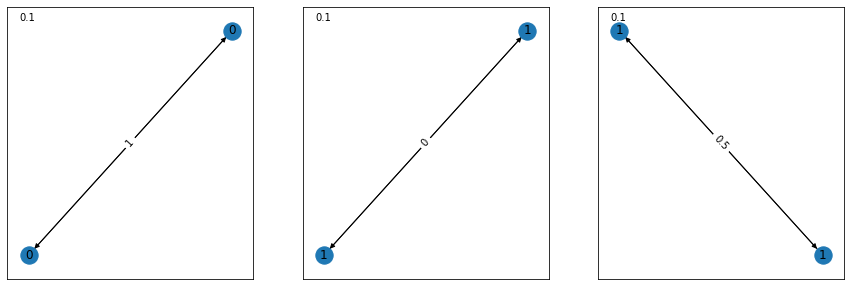

In [97]:
graph_t = utils_tf.data_dicts_to_graphs_tuple(test_graphs)
plot_graphs_tuple_np(graph_t)


###GraphNetwork 

This how to define graph networks in GraphNet. The module used below s the modeules.Interactionnetwork which only updates the edge and node and does not take into consideration global variables at all. 

The global variables apparently take up to 2 update steps in order to generate a gradient so keep that in mind. 

The activation function Tanh was used. 

In [0]:
##making graph nets you use the modules.GraphNetwork, to create a graph network
OUTPUT_EDGE_SIZE = 1 #this represents the feature space of the network 
OUTPUT_NODE_SIZE = 1 # this represents the feature space of the network. 
OUTPUT_GLOBAL_SIZE =1 #this represents the feature space of the network. 


#Node size will be used for edge. Only the data from node will be passed to edge. 
graph_network = modules.InteractionNetwork(
    #global_model_fn=lambda:snt.nets.MLP([10,OUTPUT_GLOBAL_SIZE],activation=tf.nn.tanh),
    edge_model_fn=lambda: snt.nets.MLP([10,OUTPUT_EDGE_SIZE],activation=tf.nn.tanh),
    node_model_fn=lambda:snt.nets.MLP([10,OUTPUT_NODE_SIZE],activation=tf.nn.tanh)) 


This converts the test_graph and label_graph dicts into tensor tuples, which CAN be put into the GraphNet network. 

In [0]:
test_tuples = utils_tf.data_dicts_to_graphs_tuple(test_graphs)
label_tuples = utils_tf.data_dicts_to_graphs_tuple(label_graphs)

The error function used here is MSE as the data is literally a single dimension. The loss function is parsed like below. The layout of the tuples appear to be. [0] is node data, [1] is edge data, and [2] is global data. 
Obviously here only the node and edge data are subjected to MSE. 

Optimizer was Adam. 

In [0]:
MSE=tf.keras.losses.MeanSquaredError()
op=tf.keras.optimizers.Adam()
def loss_cal(output,labels): 
  node=output[0]
  label_node=labels[0]

  edges=output[1]
  label_edges=labels[1]
  return (MSE(node,label_node)+MSE(edges,label_edges))



The most important part about the training loop was that the data can be put through the network several times arbitrarily, in a recurrent manner. Each time the data is put through the network, message passing occurs. 

In [0]:
def step(test,label):
  start= test_tuples
  previous_graph=start  
  with tf.GradientTape() as tape:
    for i in range(1):
      previous_graph= graph_network(previous_graph)
    loss = loss_cal(previous_graph,label_tuples)
    print (f'loss: ', loss)
  gr=tape.gradient(loss,graph_network.trainable_variables)
  op.apply_gradients(zip(gr,graph_network.trainable_variables))

In [118]:
for epochs in range(600): 
  for ctr in range(2): #train only the first two samples. 
    input_graphs_ = utils_tf.get_graph(test_tuples, ctr )
    target_graphs_= utils_tf.get_graph(label_tuples, ctr)
    step(input_graphs_,target_graphs_)


loss:  tf.Tensor(0.012666583, shape=(), dtype=float32)
loss:  tf.Tensor(0.012618319, shape=(), dtype=float32)
loss:  tf.Tensor(0.012570153, shape=(), dtype=float32)
loss:  tf.Tensor(0.012522083, shape=(), dtype=float32)
loss:  tf.Tensor(0.012474124, shape=(), dtype=float32)
loss:  tf.Tensor(0.012426256, shape=(), dtype=float32)
loss:  tf.Tensor(0.0123785, shape=(), dtype=float32)
loss:  tf.Tensor(0.012330831, shape=(), dtype=float32)
loss:  tf.Tensor(0.012283285, shape=(), dtype=float32)
loss:  tf.Tensor(0.012235828, shape=(), dtype=float32)
loss:  tf.Tensor(0.012188478, shape=(), dtype=float32)
loss:  tf.Tensor(0.01214123, shape=(), dtype=float32)
loss:  tf.Tensor(0.01209408, shape=(), dtype=float32)
loss:  tf.Tensor(0.012047039, shape=(), dtype=float32)
loss:  tf.Tensor(0.01200011, shape=(), dtype=float32)
loss:  tf.Tensor(0.011953269, shape=(), dtype=float32)
loss:  tf.Tensor(0.011906531, shape=(), dtype=float32)
loss:  tf.Tensor(0.0118599115, shape=(), dtype=float32)
loss:  tf.Tens

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


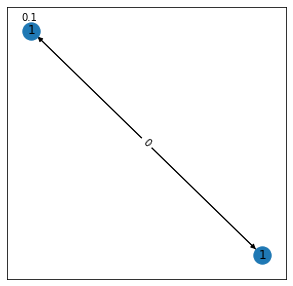

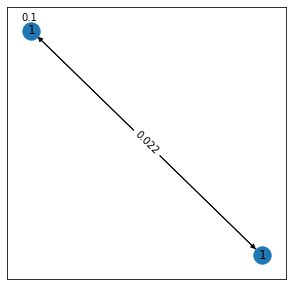

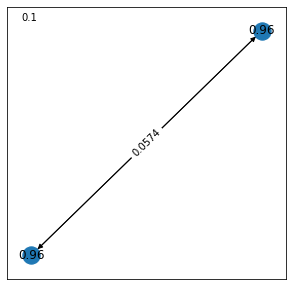

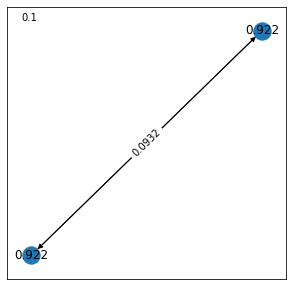

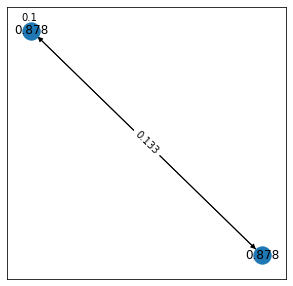

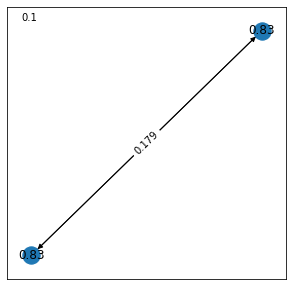

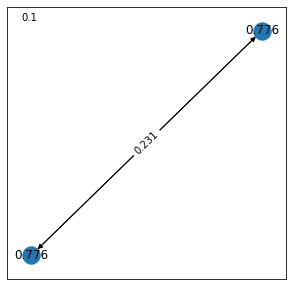

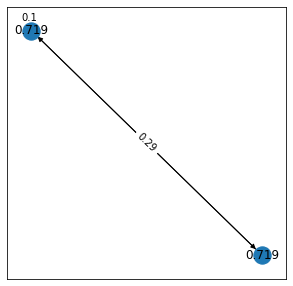

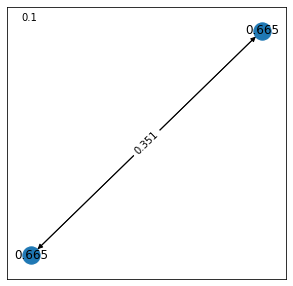

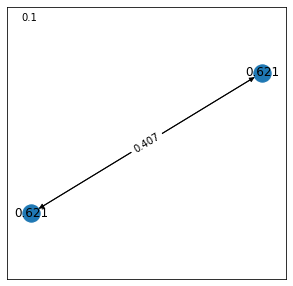

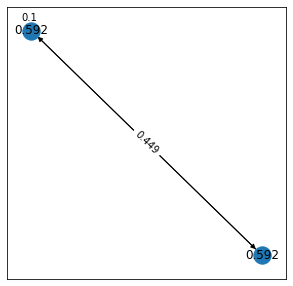

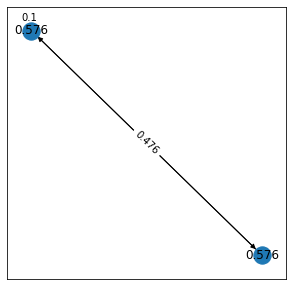

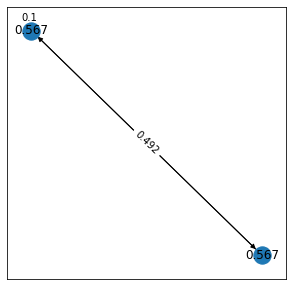

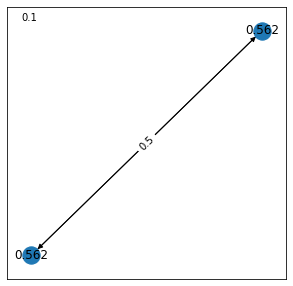

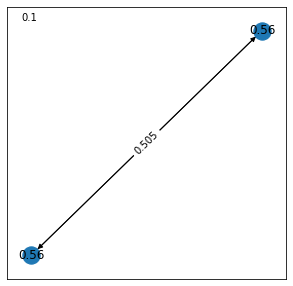

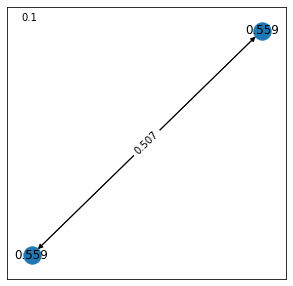

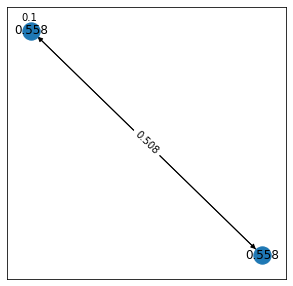

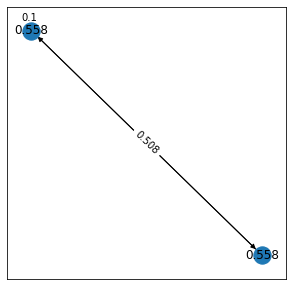

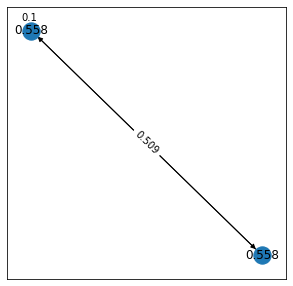

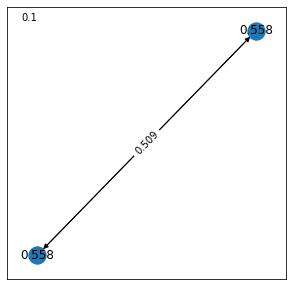

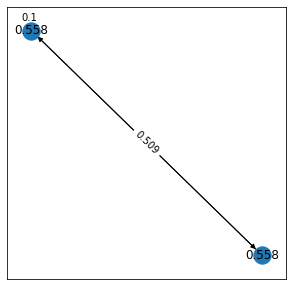

In [119]:
start= test_tuples
show_graph = utils_tf.get_graph(start, 1)
plot_graphs_tuple_np(show_graph)
previous_graph=start  
for i in range(20):
    
    previous_graph= graph_network(previous_graph)
  
    show_graph = utils_tf.get_graph(previous_graph, 1)
    
    plot_graphs_tuple_np(show_graph)